In [1]:
import pandas as pd
import geopandas as gpd

import pandas as pd
df = pd.read_excel('중구_노드_링크_네트워크데이터.xlsx')
df = df[(df['노드링크 유형'] == 'NODE') &
        (df['육교'] == 0) &
        (df['횡단보도'] == 0)]
df.head()
def multipolygon_to_coordinates(x):
    lon, lat = x[0].exterior.xy
    return [[x, y] for x, y in zip(lon, lat)]

## 다각형에서 평행좌표
def polygon_to_coordinates(x):
    lon, lat = x.exterior.xy
    return [[x, y] for x, y in zip(lon, lat)]


### geodata 변경 buffer 생성기존 24시간 가동 AED와의 유효거리 기반 수요량 b(buffer_100)
import geopandas as gpd
gs = gpd.GeoSeries.from_wkt(df['노드 WKT'])
## 좌표계 설정하는 거 같음
df_dobo_100 = gpd.GeoDataFrame(df, geometry = gs, crs = 'epsg:4326')

## 버퍼설정하는 곳인거 같음
## to_crs : 좌표계 변환
df_dobo_100 = df_dobo_100.set_geometry('geometry')
df_dobo_100['buffer_100'] = df_dobo_100.to_crs('epsg:5179').buffer(100).to_crs('epsg:4326')
df_dobo_100 = df_dobo_100.set_geometry('buffer_100')
df_dobo_100['buffer_100_coordinates'] = df_dobo_100['buffer_100'].apply(polygon_to_coordinates)

df_dobo_100['lon'] = df_dobo_100['geometry'].x
df_dobo_100['lat'] = df_dobo_100['geometry'].y


pop = pd.read_excel('중구_인구데이터.xlsx')
pop = pop.iloc[:,:4]
pop.drop('시간대구분',inplace=True,axis=1)
pop.head()

,기준일ID,행정동코드,총생활인구수
0,20231008,11140520,6686.0271
1,20231008,11140540,7505.9797
2,20231008,11140550,9002.7286
3,20231008,11140570,6983.8529
4,20231008,11140580,7685.1042


In [2]:
pop['행정동코드'] = pop['행정동코드'].astype(str)
df_dobo_100 = pd.merge(df_dobo_100, pop[['행정동코드', '총생활인구수']], how= 'left', right_on = '행정동코드', left_on = '읍면동명')

In [3]:
df_dobo_100.drop(['행정동코드_y','노드 WKT'],axis=1,inplace=True)

In [4]:
# geodata 변경 buffer 생성 - 알고리즘 제약조건 및 시각화(buffer_200)
gs = gpd.GeoSeries.from_wkt(df['노드 WKT'])
df_dobo_200 = gpd.GeoDataFrame(df, geometry = gs, crs = 'epsg:4326')

df_dobo_200 = df_dobo_200.set_geometry('geometry')
df_dobo_200['buffer_200'] = df_dobo_200.to_crs('epsg:5179').buffer(200).to_crs('epsg:4326')
df_dobo_200 = df_dobo_200.set_geometry('buffer_200')
df_dobo_200['buffer_200_coordinates'] = df_dobo_200['buffer_200'].apply(polygon_to_coordinates)

# 경도, 위도 생성
df_dobo_200['lon'] = df_dobo_200['geometry'].x
df_dobo_200['lat'] = df_dobo_200['geometry'].y

# 수요량(인구) 병합
pop['행정동코드'] = pop['행정동코드'].astype(str)
df_dobo_200['읍면동명'] = df_dobo_200['읍면동명'].astype(str)  # 필요하다면 이 부분도 추가
df_dobo_200 = pd.merge(df_dobo_200, pop[['행정동코드', '총생활인구수']], how= 'left', right_on = '행정동코드', left_on = '읍면동명')

In [5]:
!pip install pydeck
import pandas as pd
import re
import pydeck as pdk

# 노드-링크 지도에 보여주기
df = pd.read_excel('중구_노드_링크_네트워크데이터.xlsx')

df = df[(df['노드링크 유형'] == 'LINK') &
        (df['시군구명'] == '중구')]  # '중구'로 변경

df.reset_index(drop=True, inplace=True)

# 데이터 오류 정정 후 geometry 형식 변환하는 함수
def wkt_to_geometry(string):
    string = re.findall(r'\d+', string)
    lst = []
    lst.append([float(string[0] + '.' + string[1]), float(string[2] + '.' + string[3][:-3])])
    for i in range(3, len(string), 3):
        try:
            lst.append([float(string[i][-3:] + '.' + string[i+1]), float(string[i+2] + "." + string[i+3][:-3])])
        except:
            continue

    return lst

# 메모리 아웃 issue로 인한 데이터 컬럼 축소
df['geometry'] = df['링크 WKT'].apply(wkt_to_geometry)  # '링크 WKT' 컬럼이 있는지 확인 필요
df_link = df[['링크 ID','geometry']]

layer = pdk.Layer(
    'PathLayer',
    df_link,
    get_path='geometry',
    get_width=5,
    get_color='[255, 255, 120]',
    pickable=True,
    auto_highlight=True
)

# 지도 시각화
df_dobo_viz = df_dobo_200[['lon', 'lat', '총생활인구수']]  # '총생활인구수'를 시각화에 추가, 필요에 따라 수정
layer2 = pdk.Layer(
    'ScatterplotLayer',
    df_dobo_viz,
    get_position='[lon, lat]',
    get_radius=7,
    get_fill_color='[255, 0, 0]',
    pickable=True,
    auto_highlight=True
)

center = [127.0040, 37.5604]  # 중구의 중심 좌표로 변경
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13
)

r = pdk.Deck(layers=[layer, layer2], initial_view_state=view_state)
r.to_html('./wow.html')

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

In [ ]:
!pip install gurobipy
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [ ]:
df_dobo_200.columns

Index(['Unnamed: 0', '노드링크 유형', '노드 WKT', '노드 ID', '노드 유형 코드', '링크 WKT',
       '링크 ID', '링크 유형 코드', '시작노드 ID', '종료노드 ID', '링크 길이', '시군구코드', '시군구명',
       '읍면동코드', '읍면동명', '고가도로', '지하철네트워크', '교량', '터널', '육교', '횡단보도', '공원,녹지',
       '건물내', '행정동코드_x', 'geometry', 'buffer_200', 'buffer_200_coordinates',
       'lon', 'lat', '행정동코드_y', '총생활인구수'],
      dtype='object')

In [ ]:
df = df_dobo_200[['lon', 'lat']]
df = df.iloc[0:1600, :]
df = df.to_numpy()
df

array([[127.0013852 ,  37.56818744],
       [127.01697814,  37.56762897],
       [126.97646616,  37.5542738 ],
       ...,
       [126.97797528,  37.55663517],
       [126.97829733,  37.55633772],
       [126.97702814,  37.55645649]])

In [ ]:
generate_candidate_sites(df)

array([[126.99299216,  37.56117866],
       [126.99255741,  37.56243647],
       [126.97867285,  37.55215176],
       [126.99393733,  37.56246925],
       [126.98607859,  37.55591785],
       [126.99675425,  37.56520548],
       [126.97974616,  37.56531631],
       [127.02516155,  37.56261503],
       [126.9976866 ,  37.56507541],
       [127.0085284 ,  37.55287979],
       [126.98504077,  37.56522065],
       [126.96312612,  37.55442616],
       [126.97006674,  37.56512731],
       [126.98345885,  37.55057659],
       [126.99486591,  37.5604083 ],
       [127.00645226,  37.55902624],
       [127.00478078,  37.54750649],
       [126.98488864,  37.5635315 ],
       [126.96785046,  37.55219455],
       [126.96551651,  37.55476801],
       [127.02162834,  37.56059096],
       [127.00236561,  37.55317794],
       [127.01291641,  37.56007309],
       [127.00474455,  37.54765223],
       [126.99510125,  37.56173287],
       [127.02331273,  37.56860244],
       [127.01835015,  37.55475862],
 

----- Configurations -----
  Number of points 1600
  K 20
  Radius 1
  M 50
----- Output -----
  Running time : 0.21348047256469727 seconds
  Optimal coverage points: 1600


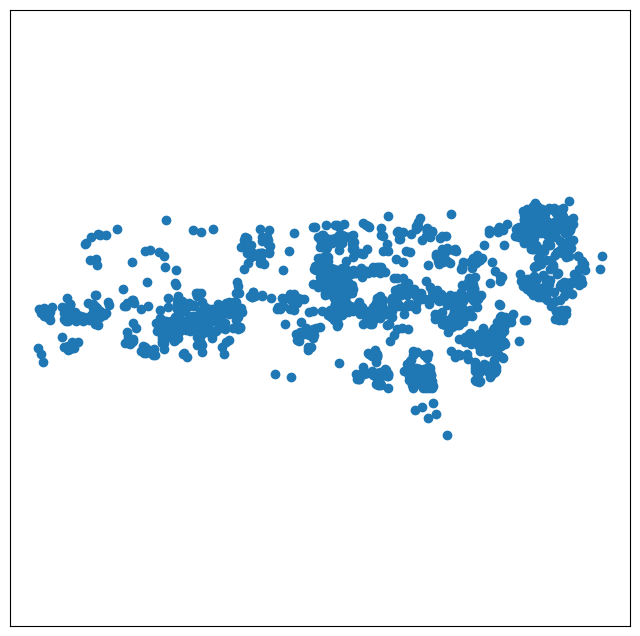

In [ ]:
mclp(df, 20, 1, 50) # 20최적위채 개수 # 반지름 # 후보군
plot_input(df)

In [ ]:
n_df = pd.read_excel('통합 문서 1.xlsx')

In [ ]:
n_df.head()

,위치,주소,x,y
0,서울특별시 중구 마장로1길 25 (신당동),서울특별시 중구 신당동 213-44,37.5689,127.0121
1,서울특별시 중구 청계천로 318 (신당동),서울특별시 중구 신당동 217-95,37.5693,127.0142
2,서울특별시 중구 퇴계로 350 (신당동),서울특별시 중구 신당동 228-17,37.5644,127.0103
3,서울특별시 중구 청구로24길 15-1 (신당동),서울특별시 중구 신당동 231-8,37.5637,127.0110
4,서울특별시 중구 다산로39길 55 (신당동),서울특별시 중구 신당동 233-2,37.5646,127.0129


In [ ]:
n_df = n_df[['x', 'y']]
n_df = n_df.to_numpy()
n_df

array([[ 37.5689, 127.0121],
       [ 37.5693, 127.0142],
       [ 37.5644, 127.0103],
       [ 37.5637, 127.011 ],
       [ 37.5646, 127.0129],
       [ 37.5626, 127.0119],
       [ 37.5621, 127.0109],
       [ 37.5644, 127.0113],
       [ 37.5631, 127.0144],
       [ 37.5653, 127.0142],
       [ 37.5672, 127.0138],
       [ 37.5628, 127.0132],
       [ 37.5634, 127.0132],
       [ 37.5619, 127.0132],
       [ 37.5632, 127.0111],
       [ 37.5609, 127.0133],
       [ 37.5609, 127.0118],
       [ 37.5634, 127.0151],
       [ 37.5643, 127.0154],
       [ 37.5672, 127.0169],
       [ 37.5667, 127.0157],
       [ 37.5702, 127.0182],
       [ 37.5667, 127.0185],
       [ 37.5675, 127.021 ],
       [ 37.5664, 127.0211],
       [ 37.5661, 127.0206],
       [ 37.5657, 127.0186],
       [ 37.5681, 127.0178],
       [ 37.5658, 127.023 ],
       [ 37.5674, 127.0223],
       [ 37.5671, 126.9952],
       [ 37.5658, 126.992 ],
       [ 37.5678, 127.0002],
       [ 37.5623, 126.9953],
       [ 37.56

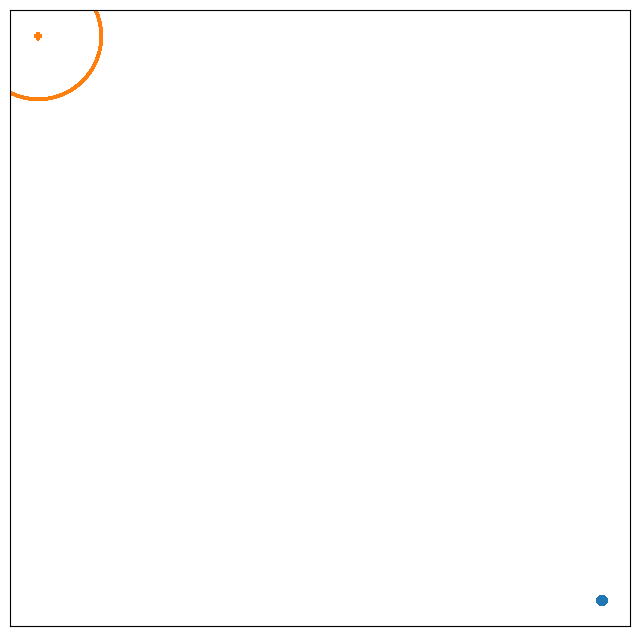

In [ ]:
plot_result(df, n_df, 10) # 1번 df는 전체 점, 2번 df는 안심벨인데 커버범위를 가지고 있는 안심벨 그 뒤에 가중치 변수들을 둘예정

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean